<a href="https://colab.research.google.com/github/Willian-WM/Dados_margrafo_nazare/blob/main/Exemplo_IA_maregrafo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementação de modelos de IA

## Previsão da altura significativa de onda da próxima hora no marégrafo costeiro de Nazaré com dados de 2018 e 2019
### Dados disponíveis em: https://monican.hidrografico.pt/maregrafo-nazare

In [ ]:
# Importação das bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.neural_network import MLPRegressor

In [ ]:
## Leitura dos dados
#Colunas dos dados
#[     0        1    2  3  4  5  6      7  ]
#[Julian Day    Y    M  D  H  M  S  SSH (m)]

data2018 = np.loadtxt('https://raw.githubusercontent.com/Willian-WM/Dados_margrafo_nazare/main/SSHNazare_Jan2018_Dec2018.dat',
                      unpack = False, skiprows=3, usecols=(0, 7))
data2019 = np.loadtxt('https://raw.githubusercontent.com/Willian-WM/Dados_margrafo_nazare/main/SSHNazare_Jan2019_Jun2019.dat',
                      unpack = False, skiprows=3, usecols=(0, 7))

In [ ]:
# Função para plotagem
# A organização de gráficos dos dados permite identificar possíveis falhas.
fig = plt.plot(data2018[:, 0], data2018[:,1], data2019[:, 0], data2019[:,1])
plt.xlabel('Date')
plt.ylabel('HHS (m)')
plt.gca().legend(('Dados 2018', 'Dados 2019'))

### Ao analisar o gráfico acima, nota-se a existência de valores anômalos próximos a 100 m.
#### Visto que estes eventos não ocorreram, é necessário remover estes dados antes de implementar os modelos de IA.
#### Para isso, será considerado valor anômalo aqueles em que a diferença da média é superior a 3 desvios padrões.

In [ ]:
# 1 Cálculo da média de 2018
mu2018 = np.mean(data2018[:,1])
# 2 Cálculo do desvio padrão de 2018
sigma2018 = np.std(data2018[:,1])
# 3 Número máximo de desvios
max_dev = 5
# 4 Normalização dos dados com média 0
norm  = abs(data2018[:,1] - mu2018)
# 5 Filtro dos dados que não são outliers
data2018_clean = data2018[norm < max_dev * sigma2018]

In [ ]:
# Gráfico com os dados sem as falhas
fig = plt.plot(data2018_clean[:, 0], data2018_clean[:,1], data2019[:, 0], data2019[:,1] )
plt.xlabel('Date')
plt.ylabel('HHS (m)')
plt.gca().legend(('Dados 2018 tratados', 'Dados 2019'))

In [ ]:
print('Formato da matriz original', data2018.shape)
print('Formato da matriz filtrada', data2018_clean.shape)

In [ ]:
# Confirmação do número de valores anômalos.
# Valor anômalo = 99.99
count = 0
for x in data2018[:, 1]:
    if x == 99.99:
        count = count +1;
print(count)

# Organização dos dados

### Como o objetivo do modelo é prever a altura da maré no próximo instante de tempo, é necessário organizar os dados de entrada e de saída:
### O modelo receberá como entrada, o dado do marégrafo no instante t, e deverá prever a altura significativa no instante t+1
### Os dados de 2018 serão utilizados para treinar o modelo, e os de 2019 para prever.

In [ ]:
# Normalização dos dados e seleção da coluna de dados de entrada
## Cálculo da média e do desvio padrão
mean = data2018_clean[:, 1].mean()
std = data2018_clean[:, 1].std()
## Normalização dos dados
data2018_norm = (data2018_clean[:, 1] - mean)/std
data2019_norm = (data2019[:, 1] - mean)/std

In [ ]:
# Visualização dos dados normalizados
# Nota-se que os dados que antes variavam no intervalo entre 0 e 4, agora variam entre -2.5 e 2.5.
# Este procedimento é utilizado para otimizar os algoritmos de IA, cujo desempenho melhora com valores pequenos.
fig = plt.plot(data2018_norm)
plt.xlabel('Date')
plt.ylabel('HHS (m)')
plt.legend(('Dados normalizados'))

## Organização dos instantes de tempo das entradas e saídas

### Cada framework exige que os vetores de entrada e saída estejam organizados de maneiras diferentes.

#### Formato de entrada de camadas densas:
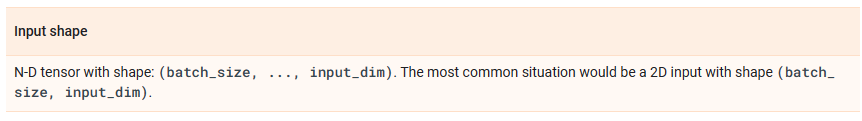
#### Formato de entrada em rede LSTM:
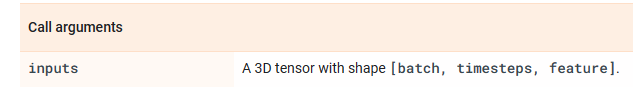

##### Fonte: https://www.tensorflow.org/

In [ ]:
##Dados de entrada devem ser normalizados, dados de saída não.
x_train_1 = data2018_norm[0:len(data2018_norm)-1]
y_train_1 = data2018_clean[1:len(data2018_norm), 1]

valid_x_1 = data2019_norm[0:len(data2019)-1]
valid_y_1 = data2019[1:len(data2019), 1]

#Reshape data para modelo sklearn
valid_x_1_skl = valid_x_1.reshape(-1, 1)
x_train_1_skl = x_train_1.reshape(-1, 1)

#Reshape para LSTM
x_train_1_lstm = x_train_1.reshape(8719, 1, 1)
x_valid_1_lstm = valid_x_1.reshape(4103, 1, 1)

In [ ]:
# Confirmação da forma dos vetores de entrada e saída.
print('Dados para modelo TF', x_train_1.shape, y_train_1.shape, valid_x_1.shape, valid_y_1.shape)
print('Dados para modelo SKL', x_train_1_skl.shape, valid_x_1_skl.shape)
print('Dados para modelo TF-LSTM', x_train_1_lstm.shape, x_valid_1_lstm.shape)

## Visualização dos dados normalizados

### Modelo 1 - Rede neural artificial com 2 camadas ocultas implementada em TensorFlow

In [ ]:
# layers.Dense - Camada totalmente conectada, units = número de neurônios, activation = Função de ativação
# Valores destes hiperparâmetros podem ser alterados para melhorar o desempenho do modelo.
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1), name='Input_1'),
    tf.keras.layers.Dense(units=30, activation = 'linear', name="Dense_1"),
    tf.keras.layers.Dense(units=10, activation = 'linear', name= "Dense_2"),
    tf.keras.layers.Dense(units=1, activation = 'linear', name= "result")
    ])

In [ ]:
# Resumo das camadas do modelo e número de parâmetros.
model_1.summary()

In [ ]:
# Plot da arquitetura do modelo:
tf.keras.utils.plot_model(model_1, to_file='archi_model_1.png', show_shapes=True)

In [ ]:
# Compilação do modelo: Definição do otimizador, função de perda e métrica de desempenho.
model_1.compile(optimizer='adam',
    loss='MeanAbsoluteError',
    metrics='mse')

In [ ]:
# model.fit - Função para treinar a RNA (determinação dos valores ótimos dos parâmetros)
# x = input; y = output; epochs = número de iterações durante o treinamento.
history = model_1.fit(x= x_train_1, y= y_train_1,
                      batch_size=64, epochs=20, verbose='auto', shuffle=False,
                      validation_data=[valid_x_1, valid_y_1],
                      validation_batch_size=64, use_multiprocessing=False
)

In [ ]:
# model.predict(Data) - Modelo determina os valores da saída para os dados de entrada fornecidos.
pred_1 = model_1.predict(valid_x_1)

In [ ]:
#Plotagem dos resultados
x_axis = np.linspace(0, len(pred_1), len(pred_1))
fig3 = plt.plot(x_axis, pred_1[:], 'g--', x_axis, valid_y_1, 'b:')
plt.xlabel('Date')
plt.ylabel('HHS (m)')
plt.gca().legend(('Previsões', 'Observado'))

In [ ]:
#Zoom no gráfico entre intervalos de interesse
i = 200
j = 300

fig4 = plt.plot( x_axis[i:j], valid_y_1[i:j], 'b:', x_axis[i-1:j-1], pred_1[i:j], 'g--')
plt.xlabel('Date')
plt.ylabel('HHS (m)')
plt.gca().legend(('Observado','Previsões'))

## Modelo 2 - RNA implementada no scikit-learn

In [ ]:
model_2 = MLPRegressor(hidden_layer_sizes=(50,), activation='tanh', solver='adam',alpha=0.0001, batch_size=1,
                       learning_rate='adaptive',learning_rate_init=0.001, max_iter=20, shuffle=False,
                       random_state=None, tol=0.0001, verbose=True, warm_start=True,
                       momentum=0.9, nesterovs_momentum=True, early_stopping=True,
                       validation_fraction=0.2).fit(x_train_1_skl, y_train_1)

In [ ]:
pred_2 = model_2.predict(valid_x_1_skl)

In [ ]:
x_axis = np.linspace(0, len(pred_2), len(pred_2))
fig3 = plt.plot(x_axis, pred_2, 'g--', x_axis, valid_y_1, 'b:')
plt.xlabel('Date')
plt.ylabel('HHS (m)')
plt.gca().legend(('Previsões', 'Observado'))

In [ ]:
#Zoom no gráfico entre intervalos de interesse
i = 200
j = 300
fig4 = plt.plot(x_axis[i:j], valid_y_1[i:j], 'b:', x_axis[i-1:j-1], pred_2[i:j], 'g--')
plt.xlabel('Date')
plt.ylabel('HHS (m)')
plt.gca().legend(('Previsões', 'Observado'))

## Modelo 3 - Rede LSTM

### Rede LSTM implementada em TensorFlow

In [ ]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, 1), name='Input_1'),
    tf.keras.layers.LSTM(30, activation='relu', recurrent_activation='sigmoid', use_bias=True, name='LSTM_1', input_shape=(200,1),
                        time_major=False),
    tf.keras.layers.Dense(10, activation='tanh', name='Dense_1'),
    tf.keras.layers.Dense(1, activation='linear', name='Dense_2')
]
)

In [ ]:
model_3.compile(optimizer='adam', loss='MeanAbsoluteError', metrics='mse')

In [ ]:
model_3.summary()

In [ ]:
# Plot da arquitetura do modelo:
tf.keras.utils.plot_model(model_3, to_file='archi_model_1.png', show_shapes=True)

In [ ]:
history = model_3.fit(x= x_train_1_lstm, y= y_train_1,
                      batch_size=32, epochs=10, verbose='auto', shuffle=False,
                      validation_data=[x_valid_1_lstm, valid_y_1],
                      validation_batch_size=1, use_multiprocessing=False
)

In [ ]:
pred_3 = model_3.predict(x_valid_1_lstm)

In [ ]:
x_axis = np.linspace(0, len(pred_3), len(pred_3))
fig3 = plt.plot(x_axis, pred_3, 'g--', x_axis, valid_y_1, 'b:')
plt.xlabel('Date')
plt.ylabel('HHS (m)')
plt.gca().legend(('Previsões', 'Observado'))

In [ ]:
#Zoom no gráfico entre intervalos de interesse
i = 200
j = 300
fig4 = plt.plot(x_axis[i:j], valid_y_1[i:j], 'b:', x_axis[i-1:j-1], pred_3[i:j], 'g--')
plt.xlabel('Date')
plt.ylabel('HHS (m)')
plt.gca().legend(('Previsões', 'Observado'))

## Comparação entre modelos

In [ ]:
#Zoom no gráfico entre intervalos de interesse
i = 250
j = 300

fig4 = plt.plot(x_axis[i:j], pred_1[i:j], x_axis[i:j], pred_2[i:j], x_axis[i:j], pred_3[i:j], 'g--',
                x_axis[i+1:j+1], valid_y_1[i:j], 'b:')
plt.xlabel('Date')
plt.ylabel('HHS (m)')
plt.legend(['TF - MLP', 'SKL - MLP','TF - LSTM','Observado'], loc=0, ncol=2)